# Hospital LOS (Length-of-Stay)
First of all what is LOS? **Hospital length-of-stay (LOS)** is defined as the time between hospital admission and discharge measured in days.

**1. Problem Statement**: The goal is to create a model that predicts the length-of-stay for each patient at time of admission.

In order to predict hospital LOS, the MIMIC data needed to be separated into terms of:
- dependent target variable (length-of-stay in this case) 
- and independent variables (features) to be used as inputs to the model. 

**2. Type of model used for prediction**
Since LOS is not a categorical but continuous variable (measured in days), a **regression model** will be used for prediction. 

**3. Metrics used for validation**
The expected outcome is that the model we use will be better at predicting hospital LOS than the industry standards of **median and average LOS**. The median LOS is simply the median LOS of past admissions to a hospital. Similarly, a second commonly used metric in healthcare is the average, or mean LOS. 

So, to measure performance of our model, we'll compare the prediction model against the median and average LOS using the root-mean-square error (RMSE). The RMSE is a commonly used measure of the differences between values predicted by a model and the values observed, where a *lower score implies better accuracy*. For example, a perfect prediction model would have an RMSE of 0. 

The RMSE equation for this work is given as follows, where (n) is the number of hospital admission records, (y-hat) the prediction LOS, and (y) is the actual LOS.

<img src="images/RMSE.png" alt="RMSE">

We could say we have a successful model if its prediction results in a lower RMSE than the average or median models.

There is a multitude of regression models available for predicting LOS. To determine the best regression model between the subset of models that will be evaluated, the **R2 (R-squared)** score will be used.

R Square measures how much variability in dependent variable can be explained by the model. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where (y_i) is an observed data point, (ŷ) is the mean of the observed data, and (f_i) the predicted model value.

<img src="images/R2.png" alt="R2">

Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

**4. Data extraction, exploration and feature engineering**

- The start point was to observe and analyze the tables in the dataset to understand how the data is distributed (Pandas libraries for Python is used to handle the tables as dataframes).
- The common functions of Pandas DataFrame to use for an overview of the table are the following:
  ``` python
  dataframe.info()
  dataframe.head()
  dataframe.describe()
  ```
- After reviewing the contents of the various tables in the MIMIC database, only some tables were selected and loaded into DataFrames using Pandas because it was assumed that it wasn't necessary or useful for prediction to include all tables. So the table selected are the following: 
    - **ADMISSIONS.csv** that defines a patient’s hospital admission, 
    - **PATIENTS.csv** that defines a single patient, 
    - **DIAGNOSES_ICD.csv** that contains ICD diagnoses for patients, most notably ICD-9 diagnoses (after this matter will be better explained),
    - **ICUSTAYS.csv** that defines a single ICU stay.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mimic3_path = '../../mimic-iii-clinical-database-1.4/'

def dataframe_from_csv(path, header=0, index_col=0):
    return pd.read_csv(path, header=header, index_col=index_col)

# read patients table
def read_patients_table(mimic3_path):
    pats = dataframe_from_csv(mimic3_path + 'PATIENTS.csv')
    # Pre-emptively don't include some columns that I don't need
    pats = pats[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']]
    pats.DOB = pd.to_datetime(pats.DOB)
    pats.DOD = pd.to_datetime(pats.DOD)
    return pats

# read admissions table
def read_admissions_table(mimic3_path):
    admits = dataframe_from_csv(mimic3_path + 'ADMISSIONS.csv')
    # Pre-emptively don't include some columns that I don't need
    admits = admits[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'INSURANCE', 'ETHNICITY', 'DIAGNOSIS']]
    admits.ADMITTIME = pd.to_datetime(admits.ADMITTIME)
    admits.DISCHTIME = pd.to_datetime(admits.DISCHTIME)
    admits.DEATHTIME = pd.to_datetime(admits.DEATHTIME)
    return admits

# read diagnoses_icd table
def read_diagnoses_icd_table(mimic3_path):
    diag_icds = dataframe_from_csv(mimic3_path + 'DIAGNOSES_ICD.csv')
    return diag_icds

# read icustays table
def read_icustays_table(mimic3_path):
    icustays = dataframe_from_csv(mimic3_path + 'DIAGNOSES_ICD.csv')
    return icustays

patients = read_patients_table(mimic3_path)
admits = read_admissions_table(mimic3_path)
diag_icds = read_diagnoses_icd_table(mimic3_path)
icustays = read_icustays_table(mimic3_path)

#example of a common function to explore data in admission table
admits.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,DIAGNOSIS
ROW_ID,,,,,,,,,
21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,Private,WHITE,BENZODIAZEPINE OVERDOSE
22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,Medicare,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,Medicare,WHITE,BRAIN MASS
24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,Private,WHITE,INTERIOR MYOCARDIAL INFARCTION
25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,Private,WHITE,ACUTE CORONARY SYNDROME


### Length of stays computation
The LOS is not explicitly expressed as attribute in the admission table, so we have to calculate it. As we said, LOS is defined as the time between admission and discharge from the hospital.

In [5]:
# Create LOS attribute converting timedelta type into float 'days', 86400 seconds in a day
admits['LOS'] = (admits['DISCHTIME'] - admits['ADMITTIME']).dt.total_seconds()/86400

# Verify LOS computation
admits[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
ROW_ID,,,
21,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
22,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
23,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
24,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
25,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [6]:
# We could already have a quick insight on how LOS values are distributed
admits['LOS'].describe() 

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

We noticed that the mean LOS is 10 days, nut we noticed also that the min LOS calculated is a negative value, how is it possible that a LOS is negative? Let's see records associated with negative values of LOS:

In [7]:
admits[admits['LOS'] < 0]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,DIAGNOSIS,LOS
ROW_ID,,,,,,,,,,
534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,Private,WHITE,ORGAN DONOR ACCOUNT,-0.372917
237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,Private,WHITE,DISSECTING ANEURYSIM,-0.138889
644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,Medicare,UNKNOWN/NOT SPECIFIED,RESPIRATORY DISTRESS,-0.797222
1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,Private,WHITE,NEWBORN,-0.113194
1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,Medicare,WHITE,STROKE;TELEMETRY,-0.100694
...,...,...,...,...,...,...,...,...,...,...
57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,Medicaid,WHITE,CARDIAC ARREST,-0.359722
58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,Medicare,WHITE,INTRACRANIAL HEMORRHAGE,-0.335417
58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,Medicaid,WHITE,GSW L. CHEST WALL & ABDOMEN,-0.332639


In [10]:
# We noticedd that rows with negative LOS, usually are related to a time of death before admission
# so in this case there is no use to predict LOS, so we drop these rows
admits = admits[admits['LOS'] > 0]
admits.describe()

,SUBJECT_ID,HADM_ID,LOS
count,58878.000000,58878.000000,58878.000000
mean,33761.791382,149966.149886,10.151266
std,28092.613275,28882.995648,12.459774
min,2.000000,100001.000000,0.001389
25%,11999.250000,124942.750000,3.755556
50%,24141.000000,149987.000000,6.489583
75%,53862.750000,174958.000000,11.805556
max,99999.000000,199999.000000,294.660417


Now we see how the min value for LOS is not negative anymore. To have a more informative view on the distribution of LOS values we plot those values:

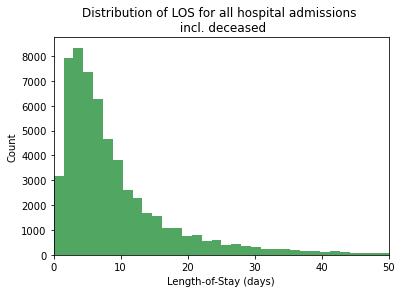

In [14]:
# Plot LOS Distribution
plt.hist(admits['LOS'], bins=200, color = '#51a662')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [20]:
# We also drop some other attributes from ADMISSIONS table that are not useful anymore for our prediction
admits.drop(['DISCHTIME', 'ROW_ID'], axis=1, inplace=True)

KeyError: "['ROW_ID'] not found in axis"